

# *PROJ-H419 - Biomedical engineering project in image analysis*

# Subject: Chest XR COVID-19 detection

## **AUTHOR**: Hassan NEHME
## **STUDENT ID**: 000436655
## **PROFESSOR**: Olivier DEBEIR
## **DATE**: 10 MAY 2022

# INTRODUCTION

<p style='text-align: justify; font-size:15px '>COVID-19 is a respiratory disease caused by severe acute respiratory syndrome coronavirus (SARS-CoV-2). The disease has caused tremendous pressure on healthcare systems and resources due to its rapid spread across the world.  Early diagnosis and isolation of patients has proven essential in slowing down the virus’s spread. Although the actual leader diagnosis test is the Reverse transcription Polymerase chain reaction (RT-PCR), it has some limitations such as being time-consuming, expensive, inaccessible in some countries, and having low sensitivity; hence, other fast and accessible diagnostic tools are needed. Inspired by recent research that correlates the presence of COVID-19 to findings in chest X-ray images we design, examine and compare different deep learning (DL) models to process and classify images into three different classes: Normal, Pneumonia and COVID-19. Starting with our proposed CNN model we extend to three different well-known DL approaches: Xception, ResNet152V2, and VGG19 based on standard benchmarks which are studied and evaluated in detail. The proposed systems involve a pre-processing stage with image augmentation, enhancement, normalisation, and resizing of CXR images. After this stage comes the classification model trained under different schemes; and finally, the result analysis and interpretation. Accuracy, precision, recall, and F-1 score are used as metrics to access the quality and performance of the proposed models. Each model will be built using the <b>Keras API</b> provided by <b>Tensorflow</b>. Some of the models have been implemented in a <b>Google Colab environement</b> which offers the Tesla K80 GPU, and the others have been implemented locally with an Apple M1 Metal GPU. </p>

# PROPOSED CONVOLUTIONNAL NEURAL NETWORK

<p style='text-align: justify; font-size:15px '>The following code helps determine the GPU that is currently being used:</p>

In [132]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-05-16 15:21:12.511094: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-16 15:21:12.511173: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7624782358750317913,
 name: "/device:GPU:0"
 device_type: "GPU"
 locality {
   bus_id: 1
 }
 incarnation: 13260913909359595948
 physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"]

## The Dataset

<p align= "justify"> The dataset contains 20000+ images in total and three classes: COVID19, Pneunomnia and Normal. It is divided into train and validation sets which can be used to develop and tune the detection/classification algorithms. 
 </p>


 The original files are available on this address: [to_kaggle](https://cxr-covid19.grand-challenge.org/). 

<p align= "justify">The datasets have been downloaded and uploaded to Google Drive for the models that have been implemented in Google Colab. In order to access the dataset in Google Colab, the following steps shown by the <i>extract_dataset()</i> function below are exectued. First, Google drive is mount in order to make its files accessible through the file system. Then, the local path is set to the content directory and the dataset is unzipped. At this stage, it is possible to browse through the contents of the drive from the file-explorer panel.</p>

The dataset is available in the content directory and is ready to be manipulated in a google colab environement.

In [133]:
#from google.colab import drive
import os

In [134]:
def extract_dataset(path, localDir):
  # Mount Google Drive
  drive.mount('/content/drive', force_remount=True)
  local_path = '/content'
  os.chdir(local_path)
  destination = "./" + localDir
  !unzip -q '{path}' -d '{localDir}'

#extract_dataset('./drive/MyDrive/covidDataset.zip', "covidDataset")

<b>NOTE</b> The dataset must be zipped and available on the drive.

## Pre-Processing the Data


### General approach

<p style='text-align: justify; font-size:15px '>During the preprocessing stage, image enhancement, image rescaling, and normalization are applied to the training dataset ( as well as the validation dataset except for data augmentation ). 
With an increased number of parameters in the model, overfitting may occur. To overcome this issue and improve generalization, augmented data with masks such as reflection, rotation, and shifting are generated for each available image. 
Moreover, as diagnosing and detecting signs of Covid or Pneumonia is a hard task in RAW-CXR images, image enhancement techniques are used to improve the overall quality, providing a more accurate analysis by increasing the visualization clarity of the margins, shadow, and borders. Adaptive contrast enhancement is used for that purpose. One popular technique is the Contrast Limited Adaptive Histogram Equalisation (CLAHE) algorithm. The original histogram equalization method uses one histogram to spread the most frequent intensity values and stretch out the intensity range. However, in the adaptive contrast enhancement algorithms, several histograms are used, each corresponding to a distinct section (neighborhood) of the image and used to redistribute the lightness values of the image. This technique is useful for improving the local contrast and enhancing the definitions of the edges in the image. Yet, this might cause an over-amplification of noise and CLAHE is a good solution to prevent that from happening by applying a contrast limiting procedure to each neighborhood.</p>

### Visualizing the Data

<p align= "justify"> Before processing the data, we must observe what we are dealing with. Below is a function that helps getting a fixed number of random samples from the training dataset; in our case we will limit ourselves to 20 samples with a resolution of 1024. Unifying the resolution is necessary in order to apply the min, max and mean built-in functions. In order to summarize the data we use this function for each category in the dataset (NORMAL, PNEUMONIA and COVID19). The samples are inserted in three different numpy arrays, one for each class. </p>

In [135]:
import cv2
import os
import random 
import matplotlib.pyplot as plt
import numpy as np

#Provides an array of size nb_samples of random image with a specific resolution from a path.
def get_rand_imgs(path, samples, nb_samples, resolution):
    try:  
      files=os.listdir(path)
    except os.error:
        print("Error listing directory...EXITING")
        
    i = 0
    while i < nb_samples:
        rand_choice =random.choice(files)
        img_path = '%s/%s'%(path, rand_choice)
        img = cv2.imread(img_path)

        if img is None or (img.shape[0], img.shape[1]) != (resolution, resolution):
            print(f'This image CANNOT be used: {rand_choice} {img.shape if img is not None else "None"}')
        else:
            samples.append(img)
            i += 1
    return np.array(samples) 

In [136]:
nb_samples = 20
resolution = 1024

rand_normal_arr = [] 
path_normal="./covidDataset/train/normal"
rand_normal_arr = get_rand_imgs(path_normal, rand_normal_arr, nb_samples, resolution)

rand_pneumonia_arr = [] 
path_pneumonia="./covidDataset/train/pneumonia"
rand_pneumonia_arr = get_rand_imgs(path_pneumonia, rand_pneumonia_arr, nb_samples, resolution)

rand_covid_arr = [] 
path_covid="./covidDataset/train/covid"
rand_covid_arr = get_rand_imgs(path_covid, rand_covid_arr, nb_samples, resolution)

This image CANNOT be used: covid-0001483.jpg (512, 512, 3)
This image CANNOT be used: covid-0003618.jpg (512, 512, 3)
This image CANNOT be used: cov_111175.jpg (909, 1082, 3)
This image CANNOT be used: covid-0001401.jpg (512, 512, 3)
This image CANNOT be used: covid-0003940.jpg (512, 512, 3)
This image CANNOT be used: cov_111582.jpg (370, 443, 3)
This image CANNOT be used: covid-0003047.jpg (512, 512, 3)
This image CANNOT be used: covid-000281.jpg (512, 512, 3)
This image CANNOT be used: covid-0002132.jpg (512, 512, 3)
This image CANNOT be used: covid-0005335.jpg (512, 512, 3)
This image CANNOT be used: cov_111378.jpg (862, 1024, 3)
This image CANNOT be used: covid-0004377.jpg (512, 512, 3)
This image CANNOT be used: covid-0004187.jpg (512, 512, 3)
This image CANNOT be used: covid-000743.jpg (512, 512, 3)
This image CANNOT be used: covid-0001846.jpg (512, 512, 3)
This image CANNOT be used: covid-0003889.jpg (512, 512, 3)
This image CANNOT be used: cov_111223.jpg (1585, 2447, 3)
This im

This image CANNOT be used: covid-0001924.jpg (512, 512, 3)
This image CANNOT be used: covid-0001481.jpg (512, 512, 3)
This image CANNOT be used: covid-0002705.jpg (512, 512, 3)
This image CANNOT be used: covid-000543.jpg (512, 512, 3)
This image CANNOT be used: covid-0001490.jpg (512, 512, 3)
This image CANNOT be used: covid-000298.jpg (512, 512, 3)
This image CANNOT be used: covid-000758.jpg (512, 512, 3)
This image CANNOT be used: covid-0005836.jpg (512, 512, 3)
This image CANNOT be used: covid-0002020.jpg (512, 512, 3)
This image CANNOT be used: covid-0001200.jpg (512, 512, 3)
This image CANNOT be used: covid-0004614.jpg (512, 512, 3)
This image CANNOT be used: covid-0005722.jpg (512, 512, 3)
This image CANNOT be used: covid-0005468.jpg (512, 512, 3)
This image CANNOT be used: covid-0004643.jpg (512, 512, 3)
This image CANNOT be used: cov_11167.jpg (914, 1024, 3)
This image CANNOT be used: covid-0005530.jpg (512, 512, 3)
This image CANNOT be used: covid-0005781.jpg (512, 512, 3)
Thi

This image CANNOT be used: cov_11136.jpg (1969, 2498, 3)
This image CANNOT be used: covid-0004549.jpg (512, 512, 3)
This image CANNOT be used: covid-0004057.jpg (512, 512, 3)
This image CANNOT be used: covid-0003601.jpg (512, 512, 3)
This image CANNOT be used: covid-0002470.jpg (512, 512, 3)
This image CANNOT be used: covid-0001490.jpg (512, 512, 3)
This image CANNOT be used: covid-0004813.jpg (512, 512, 3)
This image CANNOT be used: covid-0001602.jpg (512, 512, 3)
This image CANNOT be used: covid-0001088.jpg (512, 512, 3)
This image CANNOT be used: covid-0002252.jpg (512, 512, 3)
This image CANNOT be used: covid-0005002.jpg (512, 512, 3)
This image CANNOT be used: covid-0002942.jpg (512, 512, 3)
This image CANNOT be used: covid-0001466.jpg (512, 512, 3)
This image CANNOT be used: covid-000458.jpg (512, 512, 3)
This image CANNOT be used: covid-0004848.jpg (512, 512, 3)
This image CANNOT be used: covid-0001649.jpg (512, 512, 3)
This image CANNOT be used: cov_111369.jpg (330, 362, 3)
Thi

This image CANNOT be used: covid-000779.jpg (512, 512, 3)
This image CANNOT be used: covid-0001465.jpg (512, 512, 3)
This image CANNOT be used: covid-0003180.jpg (512, 512, 3)
This image CANNOT be used: covid-000153.jpg (512, 512, 3)
This image CANNOT be used: covid-000624.jpg (512, 512, 3)
This image CANNOT be used: covid-000882.jpg (512, 512, 3)
This image CANNOT be used: covid-0002715.jpg (512, 512, 3)
This image CANNOT be used: covid-0001945.jpg (512, 512, 3)
This image CANNOT be used: covid-0004876.jpg (512, 512, 3)
This image CANNOT be used: covid-0004104.jpg (512, 512, 3)
This image CANNOT be used: cov_111192.jpg (512, 512, 3)
This image CANNOT be used: covid-0004072.jpg (512, 512, 3)
This image CANNOT be used: covid-0004657.jpg (512, 512, 3)
This image CANNOT be used: covid-000243.jpg (512, 512, 3)
This image CANNOT be used: covid-0003914.jpg (512, 512, 3)
This image CANNOT be used: covid-0003488.jpg (512, 512, 3)
This image CANNOT be used: covid-0001260.jpg (512, 512, 3)
This 

This image CANNOT be used: cov_111577.jpg (3480, 4248, 3)
This image CANNOT be used: covid-0001939.jpg (512, 512, 3)
This image CANNOT be used: covid-0001278.jpg (512, 512, 3)
This image CANNOT be used: covid-0002438.jpg (512, 512, 3)
This image CANNOT be used: covid-0001339.jpg (512, 512, 3)
This image CANNOT be used: covid-0001003.jpg (512, 512, 3)
This image CANNOT be used: covid-0005152.jpg (512, 512, 3)
This image CANNOT be used: covid-0004280.jpg (512, 512, 3)
This image CANNOT be used: covid-0002864.jpg (512, 512, 3)
This image CANNOT be used: covid-0005734.jpg (512, 512, 3)
This image CANNOT be used: covid-0003879.jpg (512, 512, 3)
This image CANNOT be used: covid-0004779.jpg (512, 512, 3)
This image CANNOT be used: covid-0002063.jpg (512, 512, 3)
This image CANNOT be used: covid-0003636.jpg (512, 512, 3)
This image CANNOT be used: covid-0005026.jpg (512, 512, 3)
This image CANNOT be used: covid-0003518.jpg (512, 512, 3)
This image CANNOT be used: covid-0005716.jpg (512, 512, 3

<p align= "justify"> Now, it is possible to get some information about the dataset. We summarize it by reporting the shape of the images, the number of channels, the minimum, maximum and mean pixel value and getting one display per category. </p>

In [137]:
print("Summarizing the Data:")
print("")

print("Normal class: [shape: ", (rand_normal_arr[0].shape[0], rand_normal_arr[0].shape[1]), 
            "] [number of channels: ", rand_normal_arr[0].shape[2],
            "] [minimum: ", rand_normal_arr.min(),
            "] [max: ", rand_normal_arr.max(),
            "] [mean: ", rand_normal_arr.mean(), "]"
            "] [median: ", np.median(rand_normal_arr), "]"
    )

print("Pneumonia class: [shape: ", (rand_pneumonia_arr[0].shape[0], rand_pneumonia_arr[0].shape[1]), 
            "] [number of channels: ", rand_pneumonia_arr[0].shape[2],
            "] [minimum: ", rand_pneumonia_arr.min(),
            "] [max: ", rand_pneumonia_arr.max(),
            "] [mean: ", rand_pneumonia_arr.mean(), "]"
            "] [median: ", np.median(rand_pneumonia_arr), "]"
      )

print("Covid19 class: [shape: ", (rand_covid_arr[0].shape[0], rand_covid_arr[0].shape[1]), 
            "] [number of channels: ", rand_covid_arr[0].shape[2],
            "] [minimum: ", rand_covid_arr.min(),
            "] [max: ", rand_covid_arr.max(),
            "] [mean: ", rand_covid_arr.mean(), "]"
            "] [median: ", np.median(rand_covid_arr), "]"
      )

Summarizing the Data:

Normal class: [shape:  (1024, 1024) ] [number of channels:  3 ] [minimum:  0 ] [max:  255 ] [mean:  124.39765076637268 ]] [median:  131.0 ]
Pneumonia class: [shape:  (1024, 1024) ] [number of channels:  3 ] [minimum:  0 ] [max:  255 ] [mean:  127.04093737602234 ]] [median:  133.0 ]
Covid19 class: [shape:  (1024, 1024) ] [number of channels:  3 ] [minimum:  0 ] [max:  255 ] [mean:  131.6619687875112 ]] [median:  139.0 ]


#### Plotting some of the data

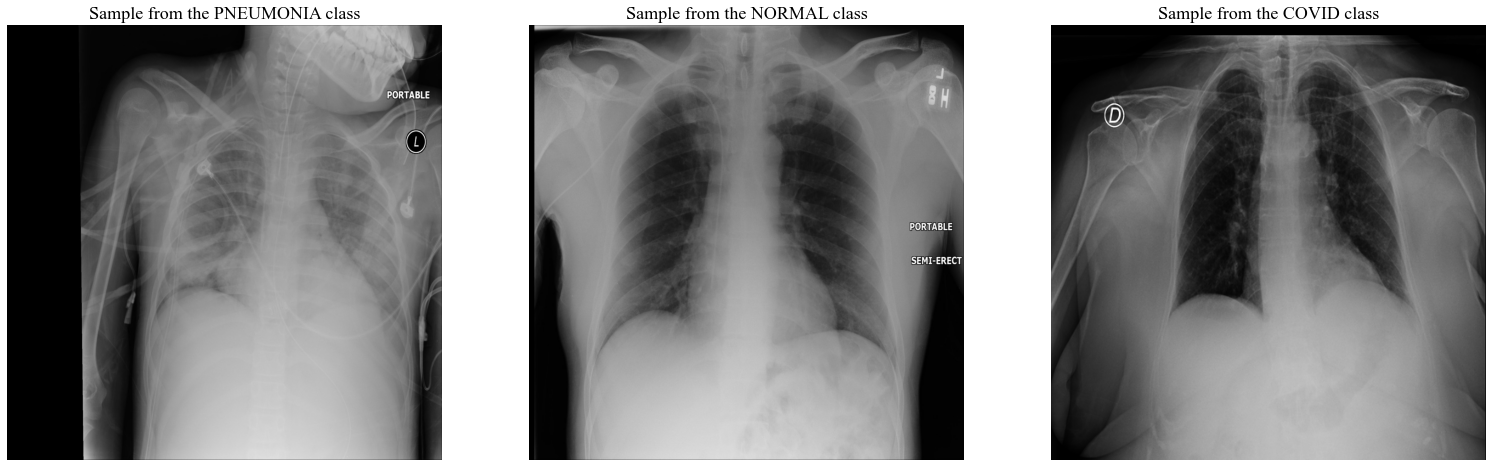

In [138]:
root_path ="./covidDataset/train"
directories = os.listdir(root_path)

i = 0
fig, axis = plt.subplots(nrows = 1, ncols = 3, figsize=(26.5, 20))
for dir in directories:
  path = root_path + "/" + dir
  files = os.listdir(path)
  for img_file in files[:1]:
    img = cv2.imread(path + "/" + img_file, 1)
    img = np.squeeze(img)

    axis[i].imshow(img)
    axis[i].set_title("Sample from the " + dir.upper() + " class", fontsize=18)
    axis[i].axis('off')
    i += 1

plt.show()

## Imbalanced dataset

### Random undersampling: A bad approach

<p align = "justify"> It is important to check if the distribution of Data is balanced in each of the three classes. As high class imbalance is naturally inherent in many real world applications and this could make the learning procedure difficult as most learners will exhibit bias towards the majority class and in extreme cases, may ignore the minority classes altogether.</p>

In [139]:
#Provides the number of images in each category of the dataset.
def get_nb_images(path):
  files = os.listdir(path) 

  for dir in files:
    if os.path.isdir(path + "/" + dir):
      direc = path + "/" + dir
      list = os.listdir(direc) 
      print("There are ", len(list), "images in the", dir.upper(), " class.")

get_nb_images(root_path)

There are  4273 images in the PNEUMONIA  class.
There are  7151 images in the NORMAL  class.
There are  6534 images in the COVID  class.


The reported values show that the dataset is imbalanced. One way to solve this is by random undersampling of the majority classes. This might seem like a reasonable idea in our case since we have thousands of images in each category and the distribution is not "heavily" imbalanced. By decreasing the number of images in the NORMAL and COVID class to 4273, it is expected that the output of the learner stays relatively similar to the case where oversampling of the minority classes is done.

In [140]:
import shutil, random, os
def undersample_class(source_path, destination_path, nb_samples):
  filenames = random.sample(os.listdir(source_path), nb_samples)
  for fname in filenames:
      srcpath = os.path.join(source_path, fname)
      destPath = os.path.join(destination_path, fname)
      shutil.copyfile(srcpath, destPath) 

#undersample_class("./covidDataset/Train/normal", "./covidDatasetBalanced/Train/normal", 4273)
#undersample_class("./covidDataset/Train/pneumonia", "./covidDatasetBalanced/Train/pneumonia", 4273)
#undersample_class("./covidDataset/Train/covid", "./covidDatasetBalanced/Train/covid", 4273)

<b>NOTE</b> In the case of Google Colab we zip the *CovidDatasetBalanced* Folder and extract its content to the local directory inside Google Colab for fast access to the data; otherwise the training will take a relatively large amount of time due to slow I/O operations. The zipping has been done outside the session. Now we can check if the new dataset *CovidDatasetBalanced* is balanced.

In [141]:
#get_nb_images("./covidDatasetBalanced/train")

The first three models that will be described later were all trained and evaluated on this balanced dataset but were all subject to overfitting. The training accuracy was much higher than the validation accuracy. This approach has been abandoned. Another possible solution is to make the model learn more from the minority class by adding class weights. This approach however was not used here and the imbalance is accepted. Nevertheless, deep learning is capable to some extent to cope with the imbalance in our case since we have a relatively large amount of data.

## Data augmentation

<p style='text-align: justify; font-size:15px '>Before feeding the data to the CNN model, the images are normalized to prevent saturation and enhance the training procedure. Moreover, images are resized to 224x224 in order to decrease the computational cost. Several augmented techniques are used to increase the size of the dataset and improve generalization. These techniques include rescaling the input, a shear of 20%, horizontal flipping, and random centering of 15%. These techniques are extremely useful to help the system recognize each image as a new entity and prevent underfitting. The desired augmentation techniques can be implemented using the <i> ImageDataGenerator </i> provided with the Keras API. Other techniques such as vertical and horizontal shifting, brightness control, and ZCA whitening have been tested extensively. However, they did not improve the performance of the learner and sometimes even degrade it. They were hence dropped and the augmentation techniques that fit best with our models and datasets were kept.</p>

Let's import Keras from Tensorflow.

In [142]:
from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image

<p style='text-align: justify; font-size:15px '>Below is given some fixed constants alongside some of the hyperparameters of our model. The choice of resizing the images to 224x224 pixels is arbitrary. This value is a very common choice in practice but we are not restricted to that choice. However, later on in this study, this will be necessary for some models that are based on convolutional neural networks that were trained on 224x224 image resolutions. The batch size of 32 is a typical choice; different sizes (like 64...etc.) have been tested and this value was the most suitable. We use a seed, which is a value drawn from a random distribution to make reproducible results in the future. we restrict ourselves to 70 epochs. A verbosity of 1 is used for animated results. </p> 

In [143]:
TARGET_SIZE = (224,224)
BATCH_SIZE = 32
SEED = 2022
SHUFFLE = True
NO_EPOCHS = 70
TRAINING_SET_SAMPLES = 17958
VALIDATION_SET_SAMPLES = 3432
VERBOSITY = 1

The generator provided by the image library in Keras runs through each image data and applies random transformations to each individual image as it is passed to the model so that it never sees the same image more than once during the training phase. The transformations are parameters on the generator that can be set when instantiated and in our case, they include rescaling, shear, horizontal flipping, and zooms. One generator is used for the training and another for validation.

<b>NOTE</b> For validation, no transformations except rescaling are applied !

In [144]:
train_datagen = image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.15,
    horizontal_flip = True,
)

In [145]:
validation_datagen = image.ImageDataGenerator(
    rescale = 1./255
)

In [146]:
train_generator = train_datagen.flow_from_directory(
    './covidDataset/train',
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = SHUFFLE,
    class_mode = "categorical",
    seed=SEED,
)

Found 17958 images belonging to 3 classes.


In [147]:
validation_generator = validation_datagen.flow_from_directory(
    './covidDataset/validation',
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "categorical",
    shuffle = SHUFFLE,
    seed = SEED,
)

Found 3432 images belonging to 3 classes.


Let's visualize three different transformations.

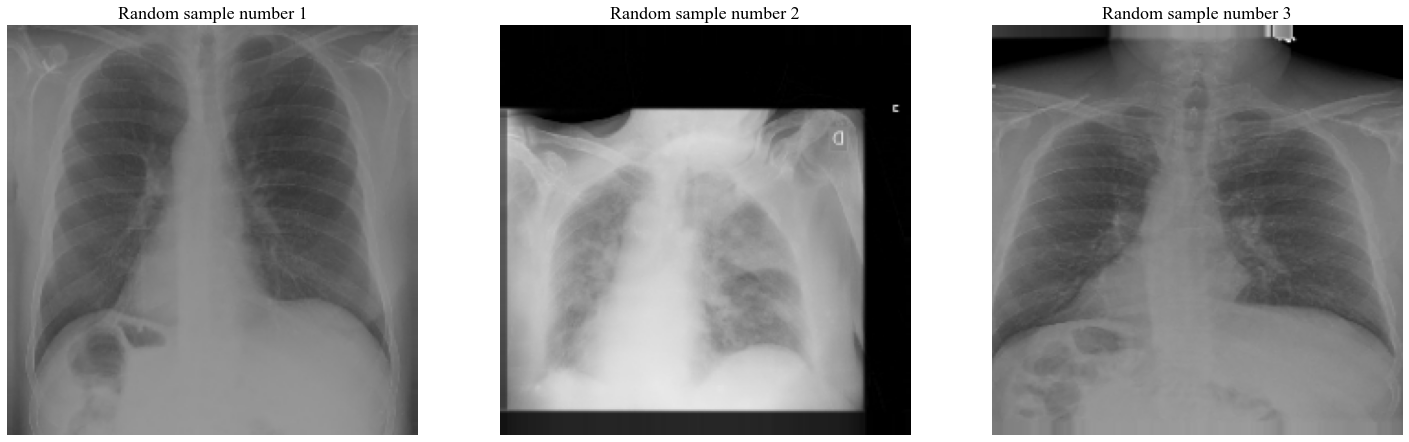

In [148]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,20))
i = 1
for axi in ax:
  image = (next(train_generator)[0][0]*255).astype('uint8')
  image = np.squeeze(image)
  axi.imshow(image)
  axi.set_title("Random sample number " + str(i), fontsize=18)
  axi.axis('off')
  i += 1

## Building the first Learner

### Architecture

<p style='text-align: justify; font-size:15px '>
The first proposed CNN network is comprised of 14 layers having three convolutional layers in which each convolutional layer is followed by a max-pooling layer. The second and third convolutional layers are followed by dropout layers. After the last dropout layer is a flatten layer which is followed by two dense layers. Between these layers there is a dropout layer followed by a batch normalization layer. In the end, a softmax layer is used for classification. Furthermore, ReLU activation function is used for each convolutional layer as well as for the first dense layer. Each convolutional layers have 32 filters of size (3x3) for feature extractions. For the max-pooling layers, a (2x2) window is used. The three dropout layers are used with a dropout of 0.5. The features extracted by the convolutional network are then flattened into a 1-dimensional vector in order to allow the classification network to classify the data using the softmax activation function into our three different classes i.e COVID, NORMAL, and PNEUMONIA before passing it through a batch normalization layer.</p>

It took around 8 hours to train that model on Google Colab.

<b>NOTE</b> These choices have been made after extensive testing. These are explained below.

<p style='text-align: justify; font-size:15px '><b>Dropout layers: </b> It has been notices that without dropout layers, the validation accuracy of the model is much worse than the training accuracy and fluctuates between ~0.4 and ~0.8. Sudden drops in the validation accuracy were observed very frequently, even after hours of training. Furthermore, a rapid increase in the loss values has been observed. These were evidence of overfitting, indicating that the model was not properly regularized. It kept learning from the training data and was not capable of generalizing the features of the training set. This motivated the introduction of dropout layers which help regularize the network by randomly selecting neurons to ignore during the training. Meaning that their contributions to the activation of the downstream neurons is temporarly stopped. The fraction of neurons to shut down is specified by the rate parameter. In our network the dropout rate is set to 0.5 for all dropout layers. Notice that there is no dropout layer after the very first convolutional layer; this prevents from loosing important early information. </p>

<p style='text-align: justify; font-size:15px '><b>Batch normalization:</b> In order to speed up the training, make it more stable, regularize the network and decrease the importance of the initial weights in the network (which we set randomly) batch normalization is used. One layer of batch normalization is used before the last two dense layers.</p>

<p style='text-align: justify; font-size:15px '><b>Softmax:</b> The mathematical function Softmax is used to convert the output vector of the values in the last dense layer into a vector of probabilities. These probabilities are propotionnal to the relative scale of each value in the vector. Therefore, it normalizes outputs and converts them from weighted sum values into values that sum up to 1. Each value in the output is interpreted as the probability of membership for each class.</p>

<p style='text-align: justify; font-size:15px '><b>Kernel size:</b> A kernel size of (3x3) is used in each convolutional layer. This is a popular choice among others like (5x5) or (7x7). However, one benefit of using small kernel size is weight sharing and the reduction in computational costs. an odd size is preferred over an even size to benefit from the symmetry of the neighborhood around the processed pixel.

In [149]:
class proposed_model:
  def __init__(self, INPUT_SHAPE, OPTIMIZER, METRICS):
      self.INPUT_SHAPE = INPUT_SHAPE
      self.OPTIMIZER = OPTIMIZER
      self.METRICS = METRICS

  def create_model(self):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=self.INPUT_SHAPE))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=self.OPTIMIZER, metrics=self.METRICS)
    self.model = model

  def get_model(self):
    return self.model

<p style='text-align: justify; font-size:15px '>As explained earlier we will use an input shape of 224x224. We are dealing with RGB images, hence we have 3 different channels. The accuracy is used as a metric to access and upgrade the model during the training phase. Moreover, <i>Adam</i> is used as our optimizer. The choice of the optimization algorithm for our deep learning model has a big impact on the final results. In practice, good results may be obtained by one algorithm in a matter of minutes whereas for another it may take hours or days. Adam is an extension of the classical stochastic gradient descent procedure, an iterative-based algorithm used to update network weights in the training stage. The algorithm was presented by <i>Diederik Kingma</i> from OpenAI and <i>Jimmy Ba</i> from the University of Toronto in 2015: <a href="https://arxiv.org/abs/1412.6980"><i>Link to the paper</i></a>. The authors listed many benefits of this algorithm on non-convex optimization problems such as being computationally efficient and requiring a relatively small amount of memory, appropriate for problems with very noisy or sparse gradients, and hyperparameters requiring little tuning and can be interpreted intuitively...etc. The effectiveness of the algorithm has been demonstrated empirically by applying it to the logistic regression algorithm of the MNIST digit recognition dataset (A standard dataset used in computer vision and deep learning) and IMDB sentiment analysis dataset. The results proved that the algorithm can efficiently solve practical deep learning problems, making it the currently recommended algorithm as the default one to be used.</p>

In [150]:
input_shape = (224, 224, 3)
metrics = ['accuracy']
optimizer = 'adam'

instance = proposed_model(input_shape, optimizer, metrics)
instance.create_model()
model = instance.get_model()

The following summary shows the network's architecture in details.

In [151]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 52, 52, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 26, 26, 32)       

In [152]:
from keras.utils.vis_utils import plot_model

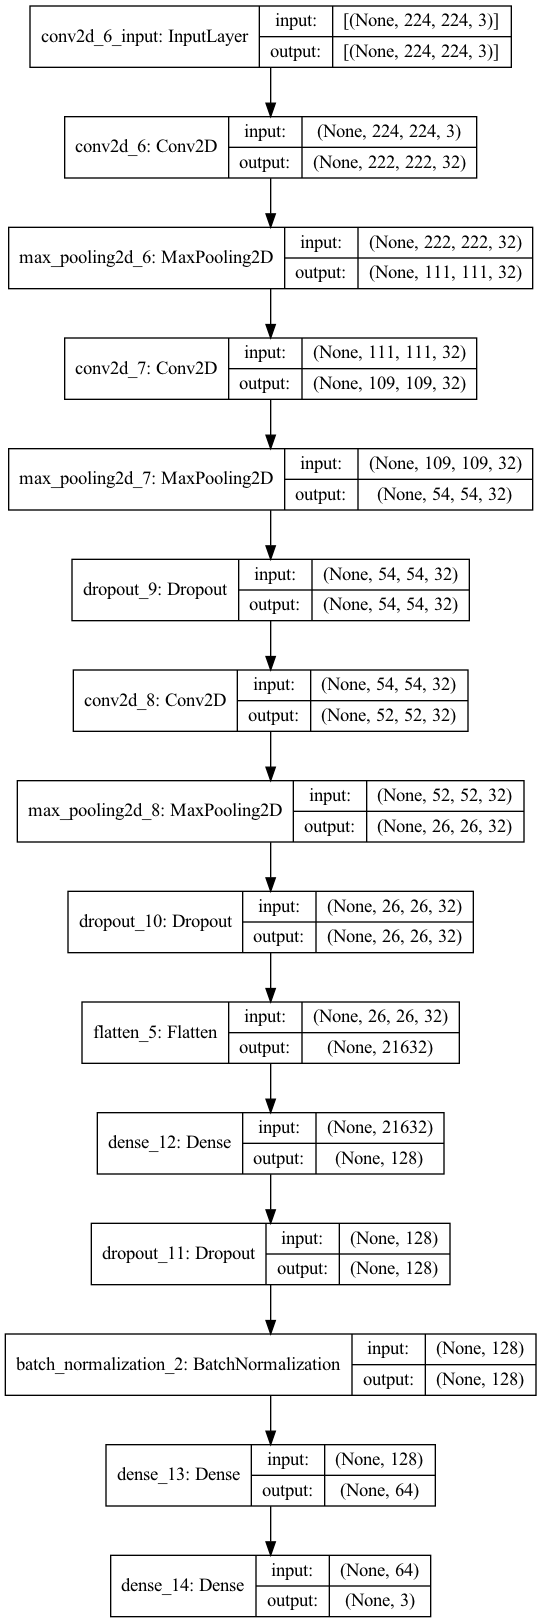

In [153]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


We can see that the total number of parameters is 2797379, and almost all of them are trainable parameters. Now is the time to train our model using the fit function from Keras.

In [154]:
def train_model(model):
    model.fit(
        train_generator,
        steps_per_epoch = TRAINING_SET_SAMPLES//BATCH_SIZE,
        epochs = NO_EPOCHS,
        verbose = VERBOSITY,
        validation_data = validation_generator,
        validation_steps = VALIDATION_SET_SAMPLES//BATCH_SIZE
    )

In [155]:
#train_model(model)

It is important to save the model's architecture, weights, and training configuration in a single file/folder. This allows to export it and later use it without accessing the original code. The state of the optimizer is recovered and the training can be resumed from exactly where it was left off. This model can be saved in 2 different file formats; the first is TF2 and HDF5. Here, the format HDF5 is chosen.

In [156]:
#model.save('./Models/standard')

The model is reconstructed by loading it directly from the directory.

In [157]:
reconstructed_model_first = keras.models.load_model('./Models/standard')

It can now be evaluated using the <i>evaluate( )</i> function from Keras which predicts the output for a given input and then computes the metrics specified during the compiling phase.

In [158]:
#reconstructed_model_first.evaluate(validation_generator)

## Analysing the results


The model accuracy is not the only performance measure for a classifier. A good way of evaluating the model is by looking at the confusion matrix. In our case, the matrix is comprised of 9 entries (3x3) where the diagonal entries correspond to correctly classified inputs and off-diagonals correspond to false classifications. It is extremely useful for measuring different metrics such as Recall, Precision, F1-score, accuracy, and more. In the case of binary classification, the diagonal entries correspond to true positives and true negatives and off-diagonals correspond to false negatives and false positives.

### Reminder

<b>Recall: </b>  The recall measures the fraction of correctly predicted samples from each category. For a binary clasification task, this can be mesured by the fraction <b>TP/(TP+FN)</b>. In our case the numerator is the number of correctly classified samples from the class "X" and the denominator is the total number of samples in the class "X". Let us denote by MAT the confusion matrix where the rows correpond to actual values and the columns to the predicted values. The recall for category 0 can be computed using <b>MAT[0 0]/(MAT[0 0]+MAT[1 0]+MAT[2 0])</b>... and so on for the rest.

<b>Precision: </b>  The precision measures the fraction of correctly classified samples from a class "X" out of all predicted "X" samples. For a binary classification task, this can be measured by <b>TP/(TP+FP)</b>. The precision for category 0 can be computed using <b>MAT[0 0]/(MAT[0 0]+MAT[1 0]+MAT[2 0])</b>... and so on for the rest.

<b> F1-score: </b> The F1 score is defined as the harmonic mean of precision and recall: 2 x (<b>Precision</b> x  <b>Recall</b>) / (<b>precision</b> + <b>Recall</b>).

The confusion matrix and the classification report are generated using sklearn.

In [159]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from keras.preprocessing import image

### Constructing a new generator


A new generator for the evaluation of the trained model is created. The batch size is set to 1 and the value of the step corresponds to the total number of samples available for testing ( This is just the value that has been generated before: 3432 ). Therefore the prediction is done over all test samples available in the test data. It is important to rescale the images as it has been done during the training. Multiprocessing is not used.

<b>NOTE</b> It is very important to set the shuffle parameter to False this time in order to conserve the order of samples in the dataset. Otherwise we won't be able to match the actual values to the predicted ones and all the metrics results will be wrong.

In [160]:
test_datagen = image.ImageDataGenerator(rescale=1. / 255)
test_dir =  './covidDataset/validation'
eval_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=TARGET_SIZE,
                                                  batch_size=1, 
                                                  shuffle=False, 
                                                  seed=2022, 
                                                  class_mode="categorical")    

Found 3432 images belonging to 3 classes.


In [161]:
eval_generator.reset()  
loss_and_accuracy = reconstructed_model_first.evaluate(
                           eval_generator,
                           steps = np.ceil(len(eval_generator)), 
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1,
                           )


print('Test loss: ' , loss_and_accuracy[0], '. Test accuracy: ', loss_and_accuracy[1])

  13/3432 [..............................] - ETA: 30s - loss: 0.0144 - accuracy: 1.0000

2022-05-16 15:21:20.690698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3432/3432 [==============================] - 26s 8ms/step - loss: 0.4098 - accuracy: 0.8421
Test loss:  0.40975964069366455 . Test accuracy:  0.8420746326446533


We can see that we obtain a loss of <b>0.41</b> and an accuracy of <b>0.842</b>

### Plotting the confusion matrix

In [162]:
filenames = eval_generator.filenames
nb_samples = len(filenames)
print('We have', nb_samples, 'samples')

We have 3432 samples


The model can predict the output using the predict function from Keras

In [163]:
prediction_standard = reconstructed_model_first.predict(eval_generator,steps = np.ceil(len(eval_generator)))
prediction_standard = np.argmax(prediction_standard, axis=-1)

2022-05-16 15:21:46.572840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


The actual labels can be obtained by extracting the classes from the evaluation generator. 

In [164]:
classes = eval_generator.classes[eval_generator.index_array]
accuracy = sum(prediction_standard==classes)/len(prediction_standard)
names = ["covid","normal","pneumonia"]

Now we can plot the confusion matrix.

 ------------------------------ Classification Report ------------------------------ 
 
              precision    recall  f1-score   support

           0       0.80      0.97      0.88      1432
           1       0.91      0.70      0.79      1000
           2       0.86      0.80      0.83      1000

    accuracy                           0.84      3432
   macro avg       0.86      0.82      0.83      3432
weighted avg       0.85      0.84      0.84      3432

    ------------------------------ Confusion Matrix ------------------------------ 
 
[[1394    8   30]
 [ 199  701  100]
 [ 141   64  795]]


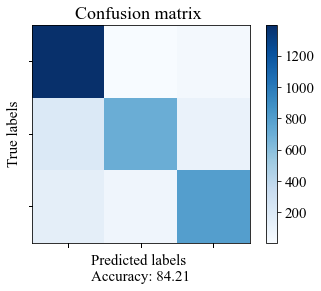

In [165]:
font = {
'family': 'Times New Roman',
'size': 15
}
plt.rc('font', **font)
       
cm = confusion_matrix(classes, prediction_standard)
print(' ------------------------------ Classification Report ------------------------------ ')
print(' ')
print(classification_report(classes,prediction_standard))

print('    ------------------------------ Confusion Matrix ------------------------------ ')
print(' ')
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted labels \nAccuracy: {:0.2f}'.format(accuracy*100))
plt.ylabel("True labels")
plt.xticks(classes, [])
plt.yticks(classes, [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

<b>NOTE </b> Class 0, 1 and 2 correspond to COVID, NORMAL and PNEUMONIA respectively.

The reported values show that the overall performance of the model is somewhat good. The precision values are above <b>80%</b> for the class 0 and 2 and reaches <b>91%</b> for class 1 (LOWEST precision is in the COVID CLASS).  The recall value is <b>97%</b> for the class 0 and <b>80%</b> for class 2 but around <b>70%</b>  for the class 1 (LOWEST recall is in the NORMAL CLASS). The F1-score is above <b>79%</b> for all classes with <b>88%</b> for class 0 and <b>83%</b> for class 2. 

# A BETTER CONVOLUTIONNAL NEURAL NETWORK

## GOAL

<p align="justify">We would like to see if the contrast enhancement has a clear impact (positive) on the learner. We show that by applying a contrast limited adaptive histogram enhancement to every image from the available data and saving them in a new dataset called <i>covidDatasetEnhanced</i>. This new dataset is then used on the same model that was proposed before and the metrics are accessed a second time.</p>

The first step is to visualize the effect of the CLAHE on a random image of the dataset.

In [166]:
#provides a random image from a path.
def read_rand_img(path):
  files=os.listdir(path)
  file=random.choice(files)
  im_path = '%s/%s'%(path,file)
  return cv2.imread(im_path)

In [167]:
#Applies the CLAHE algorithm to an image.
def apply_CLAHE(img):
  l, a, b = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2LAB))
  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
  clahe_lightness = clahe.apply(l)
  updated_img_clahe = cv2.merge((clahe_lightness, a,b))
  return clahe_lightness, cv2.cvtColor(updated_img_clahe, cv2.COLOR_LAB2BGR)

The lab color space is used. It is a 3-axis color system with dimension L for lightness and two other dimensions a and b for the colors. It is the most exact means for representing colors. The histogram of the randomly chosen image is given below.

(array([4.0140e+03, 1.0050e+03, 1.1540e+03, 1.7960e+03, 1.5170e+03,
        1.1180e+03, 1.1060e+03, 1.1720e+03, 4.9900e+02, 1.4430e+03,
        1.4450e+03, 5.0300e+02, 1.1210e+03, 1.2030e+03, 1.2570e+03,
        1.4710e+03, 2.4660e+03, 8.7900e+02, 2.8100e+03, 1.0090e+03,
        2.9590e+03, 2.1080e+03, 2.0950e+03, 3.2940e+03, 2.3020e+03,
        2.3240e+03, 2.5850e+03, 4.1520e+03, 1.4770e+03, 4.6580e+03,
        4.8610e+03, 1.6850e+03, 5.4170e+03, 3.7880e+03, 5.9040e+03,
        4.2730e+03, 6.8620e+03, 2.4420e+03, 7.6790e+03, 5.3590e+03,
        8.8020e+03, 1.0124e+04, 7.6600e+03, 1.3005e+04, 9.2060e+03,
        1.4080e+04, 9.6590e+03, 1.0115e+04, 1.0497e+04, 1.5185e+04,
        1.2483e+04, 6.6110e+03, 7.3990e+03, 3.8290e+03, 4.3000e+03,
        2.3060e+03, 2.5620e+03, 1.3420e+03, 1.5500e+03, 7.7500e+02,
        9.2800e+02, 8.5200e+02, 3.3900e+02, 3.7000e+02, 2.5900e+02,
        2.7900e+02, 1.7700e+02, 2.2700e+02, 1.3300e+02, 1.9800e+02,
        1.8900e+02, 8.2000e+01, 1.1400e+02, 6.60

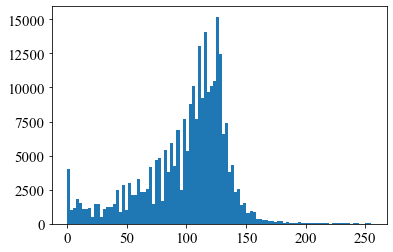

In [168]:
rand_img = read_rand_img("./covidDataset/train/covid")

lab_img = cv2.cvtColor(rand_img, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab_img)
plt.hist(l.flat, bins=100, range=(0,255))

Clahe is now applied to the chosen image and the histogram is shown below.

(array([ 519., 2531., 1222., 1247.,  679., 1141., 1055., 1353.,  893.,
        1586., 1515., 1138., 1728., 1226., 1709., 1287., 2084., 1396.,
        2008., 1454., 2235., 2222., 1568., 2455., 1573., 2545., 1786.,
        2732., 1974., 3023., 3149., 2207., 3380., 2348., 3519., 2541.,
        4055., 2775., 4312., 3028., 4977., 5084., 3630., 5711., 3834.,
        6410., 4515., 6513., 4767., 6859., 7360., 4738., 7399., 4748.,
        7079., 4512., 6663., 4168., 5892., 3718., 5230., 4866., 3191.,
        4491., 2831., 3952., 2603., 3574., 2278., 3160., 3055., 1915.,
        2671., 1702., 2391., 1515., 2163., 1325., 1994., 1244., 1783.,
        1714., 1149., 1681., 1061., 1486.,  870., 1149.,  741.,  975.,
         881.,  460.,  636.,  319.,  370.,  209.,  248.,  145.,  203.,
         138.]),
 array([  0.  ,   2.55,   5.1 ,   7.65,  10.2 ,  12.75,  15.3 ,  17.85,
         20.4 ,  22.95,  25.5 ,  28.05,  30.6 ,  33.15,  35.7 ,  38.25,
         40.8 ,  43.35,  45.9 ,  48.45,  51.  ,  53.55,  5

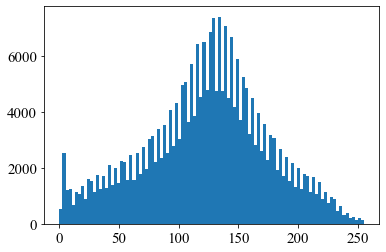

In [169]:
lightness_channel, contrasted_img = apply_CLAHE(rand_img)
plt.hist(lightness_channel.flat, bins=100, range=(0,255))

### Plotting some results

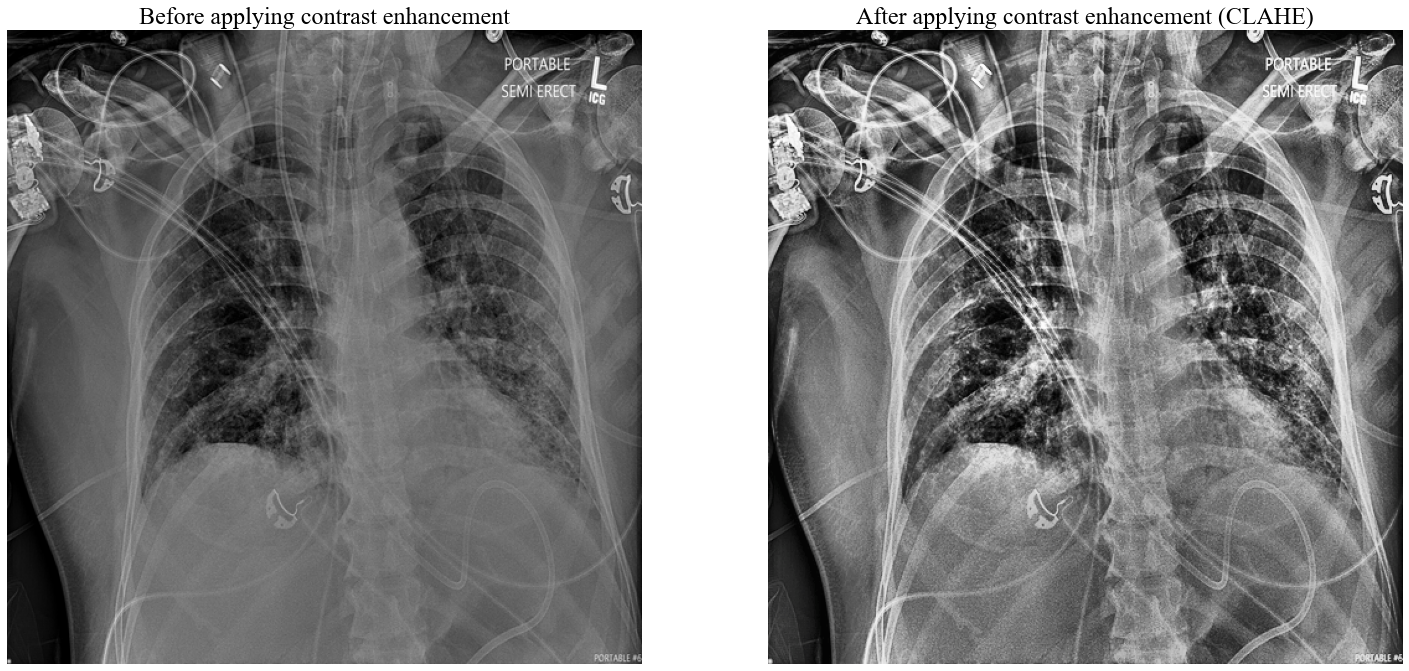

In [170]:
FONT_SIZE=24
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,20))

ax[0].set_title("Before applying contrast enhancement", fontsize=FONT_SIZE)
ax[0].imshow(rand_img)
ax[0].axis('off')

ax[1].set_title("After applying contrast enhancement (CLAHE)", fontsize=FONT_SIZE)
ax[1].imshow(contrasted_img)
ax[1].axis('off')

plt.show()

The original image and the equalized image and their corresponding histograms are shown. It can be clearly seen
that the equalization results in a slightly uniform spreading of the bins in the original histogram and the enhancement looks more natural than standard equalization techniques.

Now, that the effect of the CLAHE algorithm has been observed, a new dataset where each one of the available images in the initial dataset is enhanced using CLAHE is created.

### Building a new dataset

<p align="justify">In order to test the previous model on images with high contrast, a new dataset is created using the function <i>create_clahe_ds()</i> below. Every image in the available dataset is processed and then saved to its corresponding directory. The dataset is written on google drive and then zipped outside this session. Note that this process is applied both on the training and validation set.</p>

In [171]:
def create_clahe_ds(source, destination):
  for dir in os.listdir(source):
      subdir = source + '/' + dir
      for file in os.listdir(subdir):
        input_img = cv2.imread(subdir + '/'+file)
        contrasted_img = apply_CLAHE(input_img)[1]
        cv2.imwrite(destination + '/' + dir + '/' + file, contrasted_img)

#source_path_training = './covidDataset/train'
#destination_path_training = './covidDatasetEnhanced/train'

#source_path_validation = './covidDataset/validation'
#destination_path_validation = './covidDatasetEnhanced/validation'

### Training the model 

In [172]:
from keras.preprocessing import image

In [173]:
train_datagen_enhanced = image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.15,
    horizontal_flip = True,
)

In [174]:
validation_datagen_enhanced = image.ImageDataGenerator(
    rescale = 1./255
)

In [175]:
train_generator_enhanced = train_datagen_enhanced.flow_from_directory(
    './covidDatasetEnhanced/train',
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = SHUFFLE,
    class_mode = "categorical",
    seed=SEED,
)

Found 17958 images belonging to 3 classes.


In [176]:
validation_generator_enhanced = validation_datagen_enhanced.flow_from_directory(
    './covidDatasetEnhanced/validation',
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "categorical",
    shuffle = SHUFFLE,
    seed = SEED,
)

Found 3432 images belonging to 3 classes.


<b>NOTE </b> The exact same architecture is used for the model.

In [177]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 52, 52, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 26, 26, 32)       

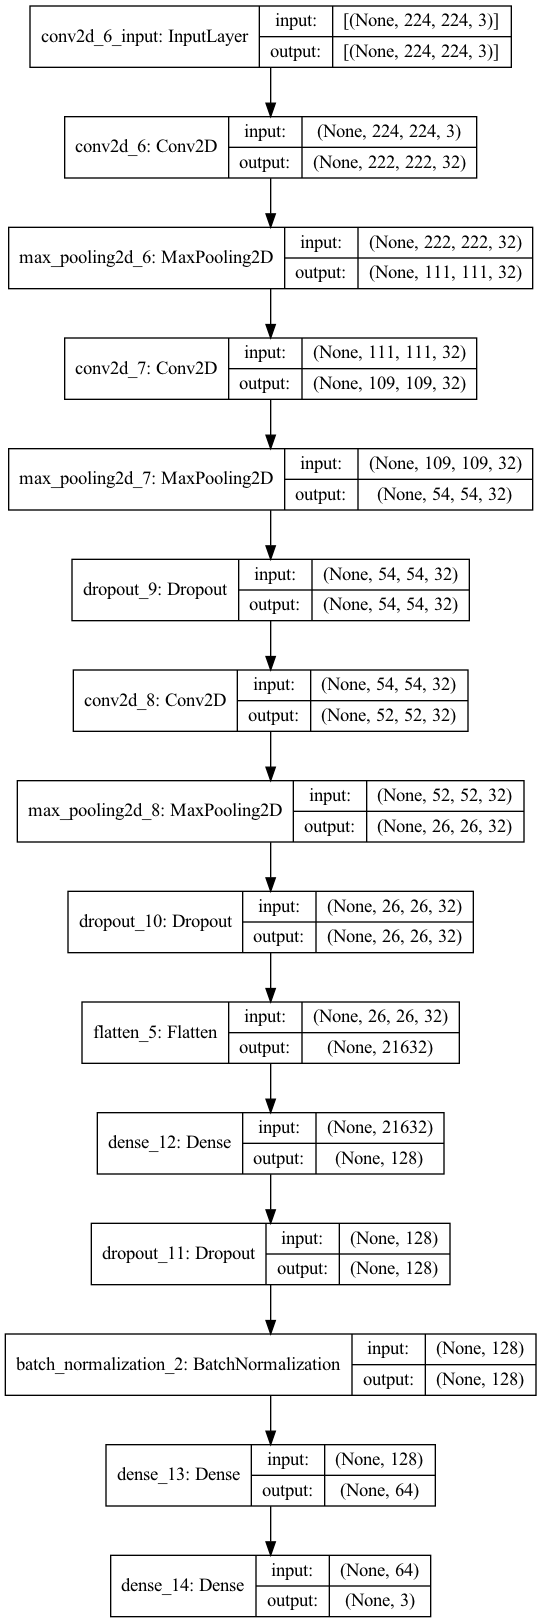

In [178]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [179]:
def train_model_clahe(model):
    return model.fit(
            train_generator_enhanced,
            steps_per_epoch = TRAINING_SET_SAMPLES//BATCH_SIZE,
            epochs = 70,
            verbose = VERBOSITY,
            validation_data = validation_generator_enhanced,
            validation_steps = VALIDATION_SET_SAMPLES//BATCH_SIZE,
          )

In [180]:
#train_model_clahe(model)

In [181]:
#model.save('./Models/standardClahe')

The model is reconstructed by loading it directly from the directory.

In [182]:
reconstructed_model_second = keras.models.load_model('./Models/standardClahe')

In [183]:
#reconstructed_model_second.evaluate(validation_generator_enhanced)

## Analysing the results

In [184]:
test_datagen = image.ImageDataGenerator(rescale=1. / 255)
test_dir =  './covidDatasetEnhanced/validation'
eval_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=TARGET_SIZE,
                                                  batch_size=1, 
                                                  shuffle=False, 
                                                  seed=2022, 
                                                  class_mode="categorical")

Found 3432 images belonging to 3 classes.


In [185]:
eval_generator.reset()  
loss_and_accuracy = reconstructed_model_second.evaluate(
                           eval_generator,
                           steps = np.ceil(len(eval_generator)), 
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1,
                           )


print('Test loss: ' , loss_and_accuracy[0], '. Test accuracy: ', loss_and_accuracy[1])

   7/3432 [..............................] - ETA: 32s - loss: 0.0038 - accuracy: 1.0000 

2022-05-16 15:22:10.859710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3432/3432 [==============================] - 54s 16ms/step - loss: 0.3885 - accuracy: 0.8581
Test loss:  0.38852381706237793 . Test accuracy:  0.8581002354621887


We can see that we obtain a loss of <b>0.388</b> and an accuracy of <b>0.858</b>

In [186]:
filenames = eval_generator.filenames
nb_samples = len(filenames)
eval_generator.reset()  

In [187]:
prediction_clahe = reconstructed_model_second.predict(eval_generator,steps = np.ceil(len(eval_generator)))
prediction_clahe = np.argmax(prediction_clahe, axis=-1)

2022-05-16 15:23:05.141528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [188]:
classes = eval_generator.classes[eval_generator.index_array]
accuracy = sum(prediction_clahe==classes)/len(prediction_clahe)
names = ["covid","normal","pneumonia"]

 ------------------------------ Classification Report ------------------------------ 
 
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      1432
           1       0.96      0.64      0.77      1000
           2       0.76      0.89      0.82      1000

    accuracy                           0.86      3432
   macro avg       0.87      0.84      0.84      3432
weighted avg       0.87      0.86      0.85      3432

    ------------------------------ Confusion Matrix ------------------------------ 
 
[[1418    2   12]
 [  88  638  274]
 [  89   22  889]]


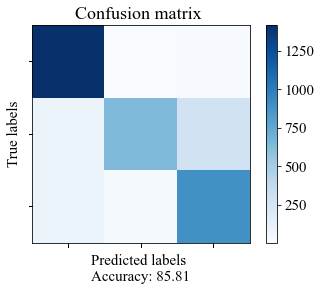

In [189]:
font = {
'family': 'Times New Roman',
'size': 15
}
plt.rc('font', **font)
       
cm = confusion_matrix(classes, prediction_clahe)
print(' ------------------------------ Classification Report ------------------------------ ')
print(' ')
print(classification_report(classes,prediction_clahe))
      
print('    ------------------------------ Confusion Matrix ------------------------------ ')
print(' ')
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted labels \nAccuracy: {:0.2f}'.format(accuracy*100))
plt.ylabel("True labels")
plt.xticks(classes, [])
plt.yticks(classes, [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

<b>NOTE </b> Class 0, 1 and 2 correspond to COVID, NORMAL and PNEUMONIA respectively.

The reported values show that the overall performance of the model is very similar to the previous model. The precision values are above <b>76%</b> for all classes and reaches <b>96%</b> for class 1 (LOWEST precision is in the PNEUMONIA CLASS).  The recall value is <b>99%</b> for the class 0 and <b>89%</b> for class 2 but around <b>64%</b> only for the class 1 (LOWEST recall is in the NORMAL CLASS). The F1-score is above <b>77%</b> for all classes with <b>94%</b> for class 0 and <b>82%</b> for class 2.

The new model shows slighlty better results with respect to our metrics. But these results are fairly close to what have been obtained previously. From now on, the enhanced dataset is going to be used by any learner.

#            A small variation in the model

## GOAL

The goal here is to check if modifiying the number of filters in the convolutional layer has a significant effect on its performance.

The number of filters in the different layers for now is set to 32 for both models. Normally, as each layer of filters captures patterns, early layers in the network extract relatively simple patterns and as we move forward into the network the patterns get more complex and therefore larger combinations of patterns become available to capture. Thus, the number of filters is increased. This concept is known as the <i>receptive field</i>. The receptive field of the network increases from one layer to another. Popular values for filters are 32, 64, 128...etc.

We increase the number of filters to 64 for the second and third convolutional layers and observe the change in performance. The contrast-enhanced dataset is used by this model. The only change is the number of filters in some of the convolutional layers. Therefore, the previous generators are used.

## Building the third Learner

In [190]:
class Standard_model_modified:
  def __init__(self, INPUT_SHAPE, OPTIMIZER, METRICS):
      self.INPUT_SHAPE = INPUT_SHAPE
      self.OPTIMIZER = OPTIMIZER
      self.METRICS = METRICS

  def create_model_modified(self):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=self.INPUT_SHAPE))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=self.OPTIMIZER, metrics=self.METRICS)
    self.model = model

  def get_model_modified(self):
    return self.model

In [191]:
input_shape = (224, 224, 3)
metrics = ['accuracy']
optimizer = 'adam'

instance = Standard_model_modified(input_shape, optimizer, metrics)
instance.create_model_modified()
model_modified = instance.get_model_modified()

In [192]:
model_modified.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 26, 26, 64)       

With this new architecture, the number of parameters has increased from 2797379 to 5603203. Hence, there are 2805824 additionnal parameters to train.


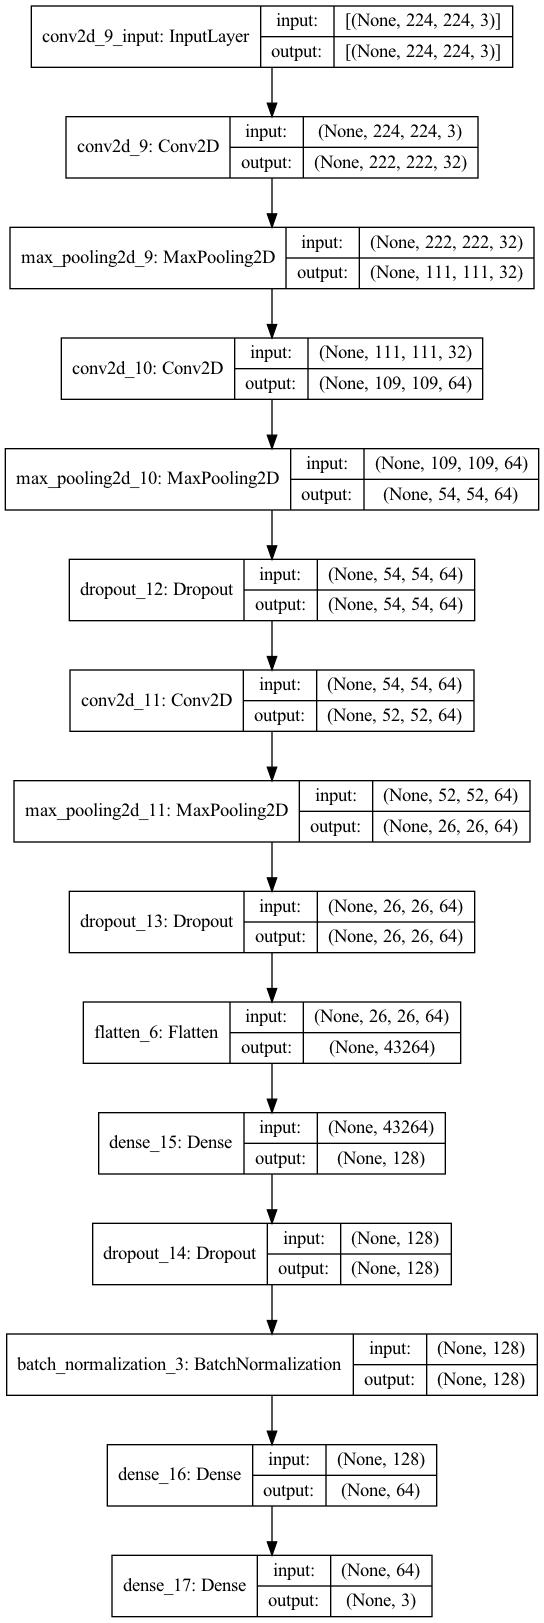

In [193]:
plot_model(model_modified, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [194]:
#train_model_clahe(model_modified)

In [195]:
#model_modified.save('./Models/standardModified')

In [196]:
reconstructed_model_third = keras.models.load_model('./Models/standardModified')

In [197]:
reconstructed_model_third.evaluate(validation_generator_enhanced)

2022-05-16 15:24:02.387748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


108/108 [==============================] - 49s 449ms/step - loss: 0.2776 - accuracy: 0.8939


[0.2776077687740326, 0.8939394354820251]

We can observe a <b>SIGNIFICANT change</b> in performance when applying these modifications. We obtain a loss of ~<b>0.278</b> and an accuracy of ~<b>0.894</b>.

## Analysing the results

As the dataset has not changed from the previous model, the same evaluation generator is used.

In [198]:
loss_and_accuracy = reconstructed_model_third.evaluate(
                           eval_generator,
                           steps = np.ceil(len(eval_generator)), 
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1,
                           )


print('Test loss: ' , loss_and_accuracy[0], '. Test accuracy: ', loss_and_accuracy[1])

3432/3432 [==============================] - 54s 16ms/step - loss: 0.2776 - accuracy: 0.8939
Test loss:  0.27760782837867737 . Test accuracy:  0.8939394354820251


In [199]:
prediction_clahe_modified = reconstructed_model_third.predict(eval_generator,steps = np.ceil(len(eval_generator)))
prediction_clahe_modified = np.argmax(prediction_clahe_modified, axis=-1)

2022-05-16 15:25:45.077979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [200]:
accuracy = sum(prediction_clahe_modified==classes)/len(prediction_clahe_modified)
names = ["covid","normal","pneumonia"]

 ------------------------------ Classification Report ------------------------------ 
 
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1432
           1       0.82      0.92      0.86      1000
           2       0.94      0.74      0.83      1000

    accuracy                           0.89      3432
   macro avg       0.89      0.88      0.88      3432
weighted avg       0.90      0.89      0.89      3432

    ------------------------------ Confusion Matrix ------------------------------ 
 
[[1407   14   11]
 [  48  916   36]
 [  65  190  745]]


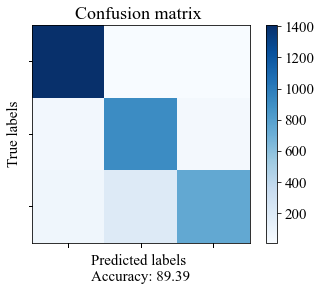

In [201]:
font = {
'family': 'Times New Roman',
'size': 15
}
plt.rc('font', **font)
       
cm = confusion_matrix(classes, prediction_clahe_modified)
print(' ------------------------------ Classification Report ------------------------------ ')
print(' ')
print(classification_report(classes,prediction_clahe_modified))
      
print('    ------------------------------ Confusion Matrix ------------------------------ ')
print(' ')
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted labels \nAccuracy: {:0.2f}'.format(accuracy*100))
plt.ylabel("True labels")
plt.xticks(classes, [])
plt.yticks(classes, [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

<b>NOTE </b> Class 0, 1 and 2 correspond to COVID, NORMAL and PNEUMONIA respectively.

It can be seen that the new model outperforms the two previously proposed models in terms of accuracy. The precision values are above <b>82%</b> for all classes and reaches <b>94%</b> for class 2 (LOWEST precision is in the NORMAL CLASS).  The recall value is <b>98%</b> for the class 0, <b>92%</b> for class 1 and around <b>74%</b> for the class 2 (LOWEST recall is in the PNEUMONIA CLASS). The F1-score is above <b>83%</b> for all classes with <b>95%</b> for class 0 and <b>86%</b> for class 1. Therefore, for the other metrics the values are similar but slightly more uniform especially in the F1-score metric.

# XCEPTION NEURAL NETWORK

Xception is a deep convolutional neural network architecture that has been designed by Google in 2017. It stands for Extreme versions of Inception. The author presented the network as being an intermediate step in-between regular convolution and the depthwise separable convolution which is a depthwise convolution that is followed by a pointwise convolution. As opposed to Inception, Xception first applies the filters on each of the depth maps and then compresses the input space using pointwise convolution by applying it across the depth. Though it is a 2017 CVPR paper that was just published a few years ago, it already had more than 8000 citations.

The last learner that we show uses Xception as a base model with a dropout layer and two fully connected layers added at the end. This model has 46 552 619 parameters in total out of which 25,691,139 are trainable and 20,861,480 are non-trainable. This model has been referred to as <b>CoroNet</b> in the literature and achieved very good results in practice for problems with 3 classes as well as 4 classes. 

Note however that the authors had more trainable parameters in their models as we set the base net weights to non-trainable parameters. This will affect the accuracy but is done in order to accelerate the training.

## Building the Xception Network

In [202]:
from tensorflow.keras.applications import Xception

In [203]:
TARGET_SIZE_XP = (224,224)
BATCH_SIZE_XP = 32
SEED = 2022
SHUFFLE = True
NO_EPOCHS_XP = 70
TRAINING_SET_SAMPLES_XP = 17958
VALIDATION_SET_SAMPLES_XP = 3432
VERBOSITY_XP = 1

In [204]:
train_datagen_xception = image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.15,
    horizontal_flip = True,
)

In [205]:
validation_datagen_xception = image.ImageDataGenerator(
    rescale = 1./255
)

In [206]:
train_generator_xception = train_datagen_xception.flow_from_directory(
    './covidDatasetEnhanced/train',
    target_size = TARGET_SIZE_XP,
    batch_size = BATCH_SIZE_XP,
    shuffle = SHUFFLE,
    class_mode = "categorical",
    seed=SEED,
)

Found 17958 images belonging to 3 classes.


In [207]:
validation_generator_xception = validation_datagen_xception.flow_from_directory(
    './covidDatasetEnhanced/validation',
    target_size = TARGET_SIZE_XP,
    batch_size = BATCH_SIZE_XP,
    class_mode = "categorical",
    shuffle = SHUFFLE,
    seed = SEED,
)

Found 3432 images belonging to 3 classes.


In [208]:
class Standard_model_Xception:
  def __init__(self, INPUT_SHAPE, OPTIMIZER, METRICS):
      self.INPUT_SHAPE = INPUT_SHAPE
      self.OPTIMIZER = OPTIMIZER
      self.METRICS = METRICS

  def create_model_Xception(self):
    base_net =  Xception(weights='imagenet',
                          include_top=False,
                          input_shape=(224, 224, 3))
    
    base_net.trainable = False
    model = Sequential()
    model.add(base_net)

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=self.OPTIMIZER, metrics=self.METRICS)
    self.model = model

  def get_model_Xception(self):
    return self.model

In [209]:
input_shape_Xception = (224, 224, 3)
metrics_Xception = ['accuracy']
optimizer_Xception = 'adam'

instance_Xception = Standard_model_Xception(input_shape_Xception, optimizer_Xception, metrics_Xception)
instance_Xception.create_model_Xception()
xception_model = instance_Xception.get_model_Xception()

In [210]:
def train_model_xception(model):
    model.fit(
    train_generator_xception,
    steps_per_epoch = TRAINING_SET_SAMPLES_XP//BATCH_SIZE_XP,
    epochs = NO_EPOCHS_XP,
    verbose = VERBOSITY_XP,
    validation_data = validation_generator_xception,
    validation_steps = VALIDATION_SET_SAMPLES_XP//BATCH_SIZE_XP
)

In [211]:
#train_model_xception(xception_model)

In [212]:
#xception_model.save('./Models/xception')

In [213]:
reconstructed_model_fourth = keras.models.load_model('./Models/xception')

In [214]:
reconstructed_model_fourth.evaluate(validation_generator_xception)

2022-05-16 15:26:45.750490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


108/108 [==============================] - 65s 597ms/step - loss: 0.4102 - accuracy: 0.8456


[0.4102408289909363, 0.8455711007118225]

We can see that we obtain a loss of <b>0.410</b> and an accuracy of <b>0.846</b>.

## Analysing the results

In [215]:
test_datagen = image.ImageDataGenerator(rescale = 1./255)
test_dir =  './covidDatasetEnhanced/validation'
eval_generator_xception = test_datagen.flow_from_directory(test_dir,
                                                  target_size=TARGET_SIZE_XP,
                                                  batch_size=1, 
                                                  shuffle=False, 
                                                  seed=SEED, 
                                                  class_mode="categorical")

Found 3432 images belonging to 3 classes.


In [216]:
loss_and_accuracy = reconstructed_model_fourth.evaluate(
                           eval_generator_xception,
                           steps = np.ceil(len(eval_generator_xception)), 
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1,
                           )


print('Test loss: ' , loss_and_accuracy[0], '. Test accuracy: ', loss_and_accuracy[1])

3432/3432 [==============================] - 116s 34ms/step - loss: 0.4102 - accuracy: 0.8456
Test loss:  0.41024088859558105 . Test accuracy:  0.8455711007118225


In [217]:
prediction_xception = reconstructed_model_fourth.predict(eval_generator_xception,steps = np.ceil(len(eval_generator_xception)))
prediction_xception= np.argmax(prediction_xception, axis=-1)

2022-05-16 15:29:47.718570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [218]:
classes = eval_generator_xception.classes[eval_generator_xception.index_array]
accuracy = sum(prediction_xception==classes)/len(prediction_xception)
names = ["covid","normal","pneumonia"]

 ------------------------------ Classification Report ------------------------------ 
 
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      1432
           1       0.80      0.88      0.84      1000
           2       0.85      0.78      0.81      1000

    accuracy                           0.85      3432
   macro avg       0.84      0.84      0.84      3432
weighted avg       0.85      0.85      0.85      3432

    ------------------------------ Confusion Matrix ------------------------------ 
 
[[1245   95   92]
 [  74  878   48]
 [ 102  119  779]]


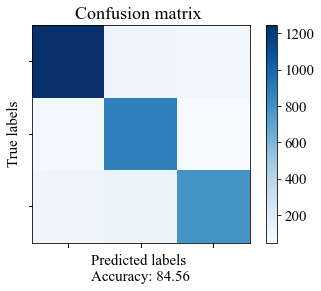

In [219]:
font = {
'family': 'Times New Roman',
'size': 15
}
plt.rc('font', **font)
       
cm = confusion_matrix(classes, prediction_xception)
print(' ------------------------------ Classification Report ------------------------------ ')
print(' ')
print(classification_report(classes, prediction_xception))
      
print('    ------------------------------ Confusion Matrix ------------------------------ ')
print(' ')
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted labels \nAccuracy: {:0.2f}'.format(accuracy*100))
plt.ylabel("True labels")
plt.xticks(classes, [])
plt.yticks(classes, [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

Class 0, 1 and 2 correspond to COVID, NORMAL and PNEUMONIA respectively.

The reported values show that the overall performance of the model is similar to the first proposed model. However, the precision values are above <b>80%</b> for all classes and reaches <b>88%</b> for class 0 (LOWEST precision is in the NORMAL CLASS).  The recall value is <b>88%</b> for the class 1 and <b>87%</b> for class 0 but around <b>78%</b> only for the class 2 (LOWEST recall is in the PNEUMONIA CLASS). The F1-score is above <b>81%</b> for all classes with <b>87%</b> for class 0 and <b>84%</b> for class 1.

## ResNet Neural Network

Since 2013, the Deep Learning community started to build deeper networks because they were able to achieve high accuracy values. Furthermore, deeper networks can represent more complex features, increasing the robustness and performance of the learner. However, accumulating layers didn’t work well for researchers in the field. While training deeper networks, the problem of accuracy degradation was observed. In other words, adding more layers to the network either made the accuracy value saturate or decrease abruptly. This problem is caused by the vanishing gradient effect which is dealt with in the ResNet architecture.

ResNet is one of the most powerful deep neural networks which has achieved excellent performance results in the ILSCRC 2015 classification challenge. It had shown excellent generalization capabilities and won first place in the ImageNet detection, localization, COCO detection, and COCO segmentation in ILSVRC and COCO 2015 competitions. There exist many variants of ResNet architectures. These differ in the number of layers but rely on the same concept. The name ResNet followed by some digits implies the ResNet architecture with a certain number of layers. For example, ResNet-18 has 18 neural network layers.  

The core idea of this architecture is the so-called “identity shortcut connection” which is introduced between the layers. The authors argue that stacking layers shouldn’t degrade the performance of the network. Simply because we could stack identity mappings upon the network and the resulting architecture must perform the same. If we consider a shallow architecture and its deeper counterpart, constructed solutions suggest that a deeper model should produce no higher training error than its shallow counterpart. They hypothesize that letting the stacked layers fit a residual mapping is better than letting them directly fit the desired underlying mapping. This is possible due to the residual block. The residual function ( also known as residual mapping ) is the function that is learned by that block and represents the difference between, the input and output of the residual block. It can be interpreted as an error between the input and the desired output. 

Note that: 152 ResNet is 8 times deeper than VGG nets ( A popular  model that we will use as our last learner ).  but requires fewer computations. 

## Building ResNet151V2

In [220]:
from tensorflow.keras.applications import ResNet152V2

In [221]:
TARGET_SIZE_RN = (224,224)
BATCH_SIZE_RN = 32
SEED = 2022
SHUFFLE = True
NO_EPOCHS_RN = 70
TRAINING_SET_SAMPLES_RN = 17958
VALIDATION_SET_SAMPLES_RN = 3432
VERBOSITY_RN = 1

train_datagen_ResNet = image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.15,
    horizontal_flip = True,
)

validation_datagen_ResNet = image.ImageDataGenerator(
    rescale = 1./255
)

train_generator_ResNet = train_datagen_ResNet.flow_from_directory(
    './covidDatasetEnhanced/train',
    target_size = TARGET_SIZE_RN,
    batch_size = BATCH_SIZE_RN,
    shuffle = SHUFFLE,
    class_mode = "categorical",
    seed=SEED,
)

validation_generator_resnet = validation_datagen_ResNet.flow_from_directory(
    './covidDatasetEnhanced/validation',
    target_size = TARGET_SIZE_RN,
    batch_size = BATCH_SIZE_RN,
    class_mode = "categorical",
    shuffle = SHUFFLE,
    seed = SEED,
)

Found 17958 images belonging to 3 classes.
Found 3432 images belonging to 3 classes.


In [222]:
class Standard_model_ResNet:
  def __init__(self, INPUT_SHAPE, OPTIMIZER, METRICS):
      self.INPUT_SHAPE = INPUT_SHAPE
      self.OPTIMIZER = OPTIMIZER
      self.METRICS = METRICS

  def create_model_ResNet(self):
    base_net =  ResNet152V2(weights='imagenet',
                          include_top=False,
                          input_shape=(224, 224, 3))
    
    base_net.trainable = False
    model = Sequential()
    model.add(base_net)

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=self.OPTIMIZER, metrics=self.METRICS)
    self.model = model

  def get_model_ResNet(self):
    return self.model

In [223]:
input_shape_ResNet = (224, 224, 3)
metrics_ResNet = ['accuracy']
optimizer_ResNet = 'adam'

instance_ResNet = Standard_model_ResNet(input_shape_Xception, optimizer_Xception, metrics_Xception)
instance_ResNet.create_model_ResNet()
ResNet_model = instance_ResNet.get_model_ResNet()

In [224]:
def train_model_ResNet(model):
    return model.fit(
    train_generator_ResNet,
    steps_per_epoch = TRAINING_SET_SAMPLES_RN//BATCH_SIZE_RN,
    epochs = NO_EPOCHS_RN,
    verbose = VERBOSITY_RN,
    validation_data = validation_generator_xception,
    validation_steps = VALIDATION_SET_SAMPLES_XP//BATCH_SIZE_RN
)

In [225]:
#hist_ResNet = train_model_ResNet(ResNet_model)

In [226]:
#ResNet_model.save('./Models/resnet')

In [227]:
reconstructed_model_fifth = keras.models.load_model('./Models/resnet')

In [228]:
reconstructed_model_fifth.evaluate(validation_generator_xception)

2022-05-16 15:31:52.409659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


108/108 [==============================] - 133s 1s/step - loss: 0.4092 - accuracy: 0.8907


[0.4092455804347992, 0.8907343149185181]

We can see that we obtain a loss of <b>0.41</b> and an accuracy of <b>0.891</b>.

## Analysing the results

In [229]:
test_datagen = image.ImageDataGenerator(rescale = 1./255)
test_dir =  './covidDatasetEnhanced/validation'
eval_generator_resnet = test_datagen.flow_from_directory(test_dir,
                                                  target_size=TARGET_SIZE_XP,
                                                  batch_size=1, 
                                                  shuffle=False, 
                                                  seed=SEED, 
                                                  class_mode="categorical")

Found 3432 images belonging to 3 classes.


In [230]:
loss_and_accuracy = reconstructed_model_fifth.evaluate(
                           eval_generator_resnet,
                           steps = np.ceil(len(eval_generator_xception)), 
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1,
                           )


print('Test loss: ' , loss_and_accuracy[0], '. Test accuracy: ', loss_and_accuracy[1])

3432/3432 [==============================] - 295s 86ms/step - loss: 0.4092 - accuracy: 0.8907
Test loss:  0.4092447757720947 . Test accuracy:  0.8907343149185181


In [231]:
prediction_resnet = reconstructed_model_fifth.predict(eval_generator_xception,steps = np.ceil(len(eval_generator_xception)))
prediction_resnet= np.argmax(prediction_resnet, axis=-1)

2022-05-16 15:38:58.202917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [232]:
classes = eval_generator_resnet.classes[eval_generator_resnet.index_array]
accuracy = sum(prediction_resnet==classes)/len(prediction_resnet)
names = ["covid","normal","pneumonia"]

 ------------------------------ Classification Report ------------------------------ 
 
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1432
           1       0.84      0.92      0.88      1000
           2       0.90      0.81      0.85      1000

    accuracy                           0.89      3432
   macro avg       0.89      0.88      0.88      3432
weighted avg       0.89      0.89      0.89      3432

    ------------------------------ Confusion Matrix ------------------------------ 
 
[[1335   47   50]
 [  45  915   40]
 [  67  126  807]]


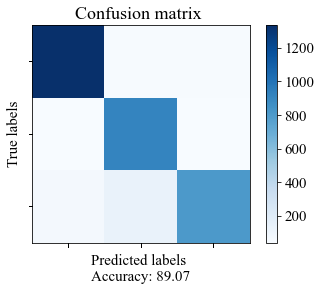

In [233]:
font = {
'family': 'Times New Roman',
'size': 15
}
plt.rc('font', **font)
       
cm = confusion_matrix(classes, prediction_resnet)
print(' ------------------------------ Classification Report ------------------------------ ')
print(' ')
print(classification_report(classes, prediction_resnet))
      
print('    ------------------------------ Confusion Matrix ------------------------------ ')
print(' ')
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted labels \nAccuracy: {:0.2f}'.format(accuracy*100))
plt.ylabel("True labels")
plt.xticks(classes, [])
plt.yticks(classes, [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

Class 0, 1 and 2 correspond to COVID, NORMAL and PNEUMONIA respectively.

The reported values show that the overall performance of the model is extremely similar to the third proposed model ( The one with the modified architecture ). In terms of accuracy, the third proposed model achieves slightly better results ( <b>89.4</b> compared to <b>89.07</b> ). On the other hand in terms of the other metrics, the results are very comparable. ResNet152V2 achieves slightly better results in the precision metric for the NORMAL class ( class 1 ), a better recall for the PNEUMONIA class ( class 2 ), and a slightly better F1-score for the NORMAL and PENUMONIA class. 

## VGG19 Neural Network

VGG19 or “Visual Geometry Group 19” is a classical convolutional neural network architecture. It was developed to increase the depth of such CNNs in order to increase the model performance. It is a standard deep CNN architecture with multiple layers. It was the basis of ground-breaking object recognition models. It also surpassed baselines on many tasks and datasets beyond ImageNet. 

Moreover, it is now still of the most popular image recognition architectures. The model was proposed by A. Zisserman and K. Simony from the University of Oxford. These researchers published their model in the research paper titled: “Very deep Convolutional Networks for Large-Scale Image Recognition”. VGG16 achieved almost 92.7% top-5 test accuracy in ImageNet. 

The concept of VGG19 is the same as VGG16 except that it supports 19 layers. The “16” and “19” stand for the number of weight layers in the model.  VGG’s convolutional layers leverage a minimal receptive field, i.e 3x3, the smallest possible size that captures in all directions.  Moreover, there are also 1x1 convolution filters acting as a linear transformation of the input. And that is followed by a ReLU activation that all hidden layers use. This network has three fully connected layers. The first two have 4096 channels each, and the third has 1000 channels. The architecture of the network is uniform. There are a few convolution layers followed by pooling layers in every “stack” and the number of filters increases as we move forward into the network. Starting with 64 filters the number increases up to 512 filters. 

## Building VGG19

In [234]:
from tensorflow.keras.applications import VGG19

In [235]:
TARGET_SIZE_VGG = (224,224)
BATCH_SIZE_VGG = 32
SEED = 2022
SHUFFLE = True
NO_EPOCHS_VGG = 70
TRAINING_SET_SAMPLES_VGG = 17958
VALIDATION_SET_SAMPLES_VGG = 3432
VERBOSITY_VGG = 1

train_datagen_VGG = image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.15,
    horizontal_flip = True,
)

validation_datagen_VGG = image.ImageDataGenerator(
    rescale = 1./255
)

train_generator_VGG = train_datagen_VGG.flow_from_directory(
    './covidDatasetEnhanced/train',
    target_size = TARGET_SIZE_VGG,
    batch_size = BATCH_SIZE_VGG,
    shuffle = SHUFFLE,
    class_mode = "categorical",
    seed=SEED,
)

validation_generator_VGG = validation_datagen_VGG.flow_from_directory(
    './covidDatasetEnhanced/validation',
    target_size = TARGET_SIZE_VGG,
    batch_size = BATCH_SIZE_VGG,
    class_mode = "categorical",
    shuffle = SHUFFLE,
    seed = SEED,
)

Found 17958 images belonging to 3 classes.
Found 3432 images belonging to 3 classes.


In [236]:
class Standard_model_VGG:
  def __init__(self, INPUT_SHAPE, OPTIMIZER, METRICS):
      self.INPUT_SHAPE = INPUT_SHAPE
      self.OPTIMIZER = OPTIMIZER
      self.METRICS = METRICS

  def create_model_VGG(self):
    base_net =  VGG19(weights='imagenet',
                          include_top=False,
                          input_shape=self.INPUT_SHAPE)
    
    base_net.trainable = False
    model = Sequential()
    model.add(base_net)

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=self.OPTIMIZER, metrics=self.METRICS)
    self.model = model

  def get_model_VGG(self):
    return self.model

In [237]:
input_shape_VGG = (224, 224, 3)
metrics_VGG = ['accuracy']
optimizer_VGG = 'adam'

instance_VGG = Standard_model_VGG(input_shape_VGG, optimizer_VGG, metrics_VGG)
instance_VGG.create_model_VGG()
VGG_model = instance_VGG.get_model_VGG()

In [238]:
def train_model_VGG(model):
    return model.fit(
    train_generator_VGG,
    steps_per_epoch = TRAINING_SET_SAMPLES_VGG//BATCH_SIZE_VGG,
    epochs = NO_EPOCHS_VGG,
    verbose = VERBOSITY_VGG,
    validation_data = validation_generator_VGG,
    validation_steps = VALIDATION_SET_SAMPLES_VGG//BATCH_SIZE_VGG
)

In [239]:
#hist_vgg = train_model_VGG(VGG_model)

In [240]:
#VGG_model.save('./Models/vgg')

In [241]:
reconstructed_model_sixth = keras.models.load_model('./Models/vgg')

In [242]:
reconstructed_model_sixth.evaluate(validation_generator_xception)

2022-05-16 15:43:42.732997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


108/108 [==============================] - 191s 2s/step - loss: 0.3157 - accuracy: 0.8872


[0.3157416880130768, 0.8872377872467041]

## Analysing the results

In [243]:
test_datagen = image.ImageDataGenerator(rescale = 1./255)
test_dir =  './covidDatasetEnhanced/validation'
eval_generator_vgg = test_datagen.flow_from_directory(test_dir,
                                                  target_size=TARGET_SIZE_VGG,
                                                  batch_size=1, 
                                                  shuffle=False, 
                                                  seed=SEED, 
                                                  class_mode="categorical")

Found 3432 images belonging to 3 classes.


In [244]:
loss_and_accuracy = reconstructed_model_sixth.evaluate(
                           eval_generator_vgg,
                           steps = np.ceil(len(eval_generator_vgg)), 
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1,
                           )


print('Test loss: ' , loss_and_accuracy[0], '. Test accuracy: ', loss_and_accuracy[1])

3432/3432 [==============================] - 222s 65ms/step - loss: 0.3157 - accuracy: 0.8872
Test loss:  0.3157413899898529 . Test accuracy:  0.8872377872467041


We can see that we obtain a loss of <b>0.3157</b> and an accuracy of <b>0.887</b>.

In [245]:
prediction_vgg = reconstructed_model_sixth.predict(eval_generator_vgg,steps = np.ceil(len(eval_generator_xception)))
prediction_vgg= np.argmax(prediction_vgg, axis=-1)

2022-05-16 15:50:35.646329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [246]:
classes = eval_generator_vgg.classes[eval_generator_vgg.index_array]
accuracy = sum(prediction_vgg==classes)/len(prediction_vgg)
names = ["covid","normal","pneumonia"]

 ------------------------------ Classification Report ------------------------------ 
 
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      1432
           1       0.80      0.95      0.87      1000
           2       0.88      0.81      0.84      1000

    accuracy                           0.89      3432
   macro avg       0.88      0.89      0.88      3432
weighted avg       0.89      0.89      0.89      3432

    ------------------------------ Confusion Matrix ------------------------------ 
 
[[1286   70   76]
 [  12  950   38]
 [  25  166  809]]


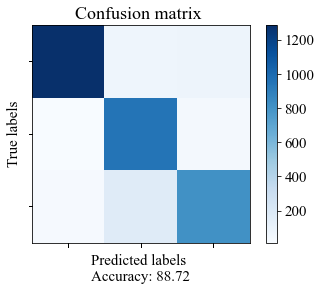

In [247]:
font = {
'family': 'Times New Roman',
'size': 15
}
plt.rc('font', **font)
       
cm = confusion_matrix(classes, prediction_vgg)
print(' ------------------------------ Classification Report ------------------------------ ')
print(' ')
print(classification_report(classes, prediction_vgg))
      
print('    ------------------------------ Confusion Matrix ------------------------------ ')
print(' ')
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted labels \nAccuracy: {:0.2f}'.format(accuracy*100))
plt.ylabel("True labels")
plt.xticks(classes, [])
plt.yticks(classes, [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

Class 0, 1 and 2 correspond to COVID, NORMAL and PNEUMONIA respectively.

The reported values show that the overall performance of the model is also very similar to the third proposed model ( The one with the modified architecture ). In terms of accuracy, the third proposed model achieves better results ( <b>89.4</b> compared to <b>88.72</b> ). On the other hand in terms of the other metrics, the results are very comparable. VGG19 achieves a much better precision for the COVID-19 class (<b>97%</b> compared to <b>93%</b> ), a slightly better recall and F1-score for the NORMAL class ( class 1 ) and the PNEUMONIA class ( class 2 ). However the recall value is much lower ( <b>90%</b> compared to <b>98%</b> ).

# CONCLUSION

<p style='text-align: justify; font-size:15px '>Different convolutional neural networks were proposed and compared for the detection of the COVID-19 disease in Chest XR image. A simple but robust deep-learning convolutional neural network is  proposed and trained on a set of 17 000+ images. This dataset was modified to include only contrasted images that are generated using the CLAHE algorithm; showing a slight improvement in the metrics. Through the analysis and experimentation the architecture was slightly modified to increase the receptive field and achieve a maximum accuracy rate of 89.39%. The last three models are based on a transfer learning approach. Each one of these models has shown good performance with respect to one of the metrics that we set. Nevertheless, the accuracy measure is the one that we are most interested in. And with respect to that metric, ResNet152V2 is the one that performs best. However, the model that we proposed as our third learner has shown a comparable performance but has a much simpler architecture and is easier to train. But It is also important to keep in mind that we froze the layers of the last three models. This means the weights of the layers in the base model were not trained and only the weights of the model on top of the base architecture were trained.  This is a typical workflow when using a transfer-learning approach. Fine-tuning could also be implemented to get some improvements. </p>

# To finish... Let's test on a single image.

In [253]:
def get_max_idx(arr):
    curr_max = -10000
    curr_idx = -1
    for i in range(len(arr)):
        if arr[i] > curr_max:
            curr_max = arr[i]
            curr_idx = i
    
    return curr_max, curr_idx

In [254]:
from skimage import transform
labels = {0: 'covid', 1: 'normal', 2: 'pneumonia'}

In [255]:
def get_rand_img(path):
    root_choice = random.choice(os.listdir(path))
    prefix = '%s/%s'%(path, root_choice)
    rand_img_file = random.choice(os.listdir(prefix))
    return '%s/%s'%(prefix, rand_img_file), root_choice

 ----------------------- Probabilities ----------------------- 
 
[[9.9534792e-01 3.6974044e-03 9.5469720e-04]]
 
 ----------------------- Highest score ----------------------- 
99.535
 
 ------------------------- Image ------------------------- 
Our model predicts it to be part of the covid class! Actual:  covid class! 


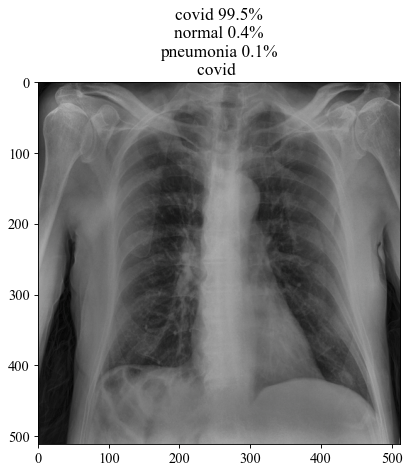

In [268]:
img_rand, actual = get_rand_img('./covidDatasetEnhanced/validation')

img_rand = cv2.imread(img_rand)
transform_1 = np.array(img_rand).astype('float32')/255
transform_2 = transform.resize(transform_1, (224, 224, 3))
img = np.expand_dims(transform_2, axis=0)
prediction=reconstructed_model_third.predict(img)

print(' ----------------------- Probabilities ----------------------- ')
print(' ')
print(prediction)
index = np.argmax(prediction)
category=labels.get(index)
prediction = [item for sublist in prediction for item in sublist]

print(' ')
print(' ----------------------- Highest score ----------------------- ')
#highest_val, predicted_class_idx = round(max(prediction)*100, 3)

highest_val, predicted_class_idx = get_max_idx(prediction)
highest_val = round(highest_val*100, 3)
print(highest_val)

font = {
'family': 'Times New Roman',
'size': 13,
}

print(' ')
print(' ------------------------- Image ------------------------- ')
names = list(labels.values())
plt.rc('font', **font)
plt.figure(figsize=(8, 6), dpi=80)
plt.title(names[0] + " "+ str(round(prediction[0]*100,1))+
                          "%"+"\n"+names[1] +" "+ 
                          str(round(prediction[1]*100,1))+
                          "%"+"\n"+names[2] +" "+ 
                          str(round(prediction[2]*100,1))+"%"+"\n"+actual + " ")
                       
plt.imshow(img_rand) 
print("Our model predicts it to be part of the", names[predicted_class_idx], "class! Actual: ", actual, "class! ")